# Introduction

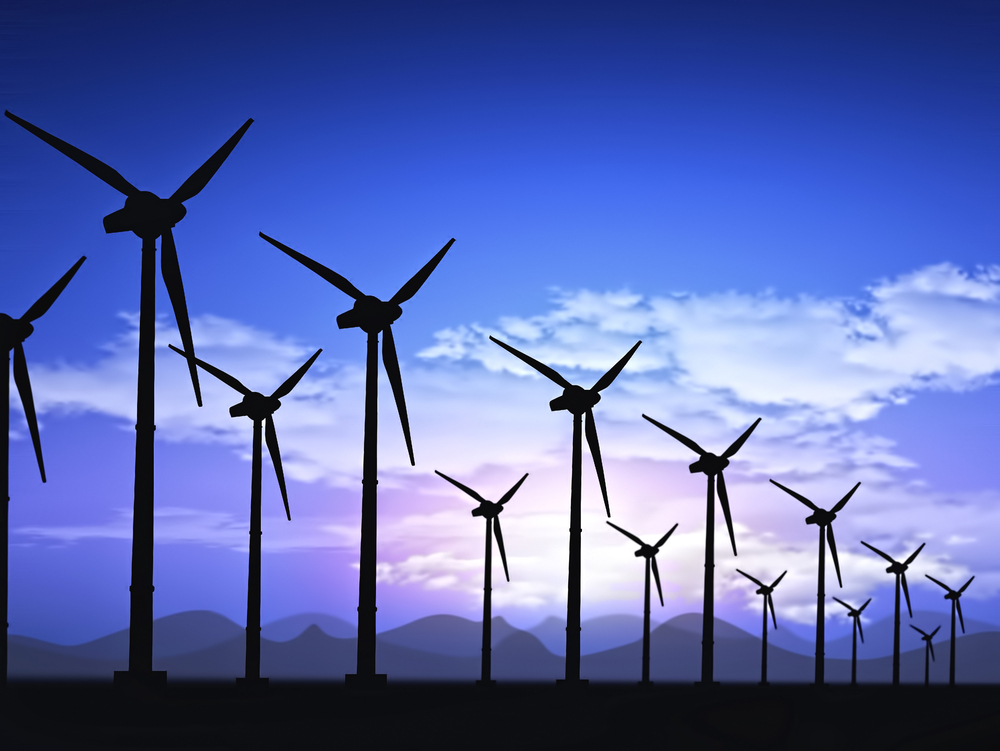

In [3]:
from IPython.display import Image
Image('img.jpg', width=600, height=None)



In this project, we are working with a dataset that was specifically simulated to analyze the feasibility of maintaining grid stability under Distributed Smart Grid Control (DSGC). The dataset assumes a 4-node architecture comprising one electricity producer and three consumers. Key details of the dataset include:

- **Total Instances**: 10,000
- **Attributes**: 12

**Attributes Description**

1. **Power (p[x])**:
    - `p1 to p4`: Power produced or consumed by each node.
    - `p1`: Calculated as the absolute value of the sum of `p2`, `p3`, and `p4`.

2. **Adaptation Willingness (g[x])**:
    - `g1 to g4`: Indicates how willing each node is to adapt their consumption or production per second.
    - This value is proportional to the price elasticity (gamma).

3. **Adaptation Time (tau[x])**:
    - `tau1 to tau4`: The time it takes for each node to adapt their production or consumption, measured in seconds.

- `p1`, `g1`, and `tau1` are specifically related to the electricity producer, while the remaining values pertain to the electricity consumers.

**Target Variables**

- **stab**: A numerical value representing grid stability (a positive value indicates instability).
- **stabf**: A categorical version of `stab`, simplifying the stability status.


# Libraries


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
import math
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import random
from sklearn.preprocessing import StandardScaler
import warnings
warnings.simplefilter(action='ignore',category=FutureWarning)
warnings.simplefilter(action='ignore',category=RuntimeWarning)

In [6]:
smart_grid_orig = pd.read_csv("Data_Electrical_Grid_Stability\Data_for_UCI_named.csv")
smart_grid = smart_grid_orig.copy()

# Functions

In [7]:
def unique(smart_grid):
 for col in smart_grid.columns:
  unique_values = smart_grid[col].explode().unique()
  typee = smart_grid[col].dtype
  if len(unique_values) > 50:
   print(f"{col} has {len(unique_values)} unique values")
  else:
    print(f"{col} contains: {', '.join(map(str, unique_values))}")

def missing(smart_grid):
  missing_count = smart_grid.isnull().sum()
  total_values = smart_grid.shape[0]
  missing_percentage = (missing_count / total_values) * 100
  missing_data_summary = pd.DataFrame({
      '\033[1mMissing Count\033[0m': missing_count,
      '\033[1mMissing Percentage\033[0m': missing_percentage
  })
  print(missing_data_summary)

def desc_cols(smart_grid):
  numeric_cols = smart_grid.columns[smart_grid.dtypes!='object']
  categorical_cols = smart_grid.columns[smart_grid.dtypes=='object']
  print("\033[1mNumber of Numerical Cols",len(numeric_cols),"\033[0m")
  print(list(numeric_cols))
  print('-'*85)
  print("\033[1mNumber of Catageroical Cols",len(categorical_cols),"\033[0m")
  print(list(categorical_cols))

def check_outliers(df):
    outliers_dict = {}
    for col in df.columns:
        # Calculate Q1, Q3, and IQR for each column
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        # Define bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Identifying the outliers in the column
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

        # Storing the results in the dictionary
        outliers_dict[col] = {'count': len(outliers)}

    # Return the dictionary containing outlier information for each column
    return outliers_dict

def scaling(df):
  scaler = StandardScaler()
  return scaler,pd.DataFrame(scaler.fit_transform(df))


# EDA

In [8]:
smart_grid.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,unstable
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,stable
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,unstable
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,unstable
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,unstable


In [9]:
desc_cols(smart_grid)

Number of Numerical Cols 13 
['tau1', 'tau2', 'tau3', 'tau4', 'p1', 'p2', 'p3', 'p4', 'g1', 'g2', 'g3', 'g4', 'stab']
-------------------------------------------------------------------------------------
Number of Catageroical Cols 1 
['stabf']


In [10]:
unique(smart_grid)

tau1 has 10000 unique values
tau2 has 10000 unique values
tau3 has 10000 unique values
tau4 has 10000 unique values
p1 has 10000 unique values
p2 has 10000 unique values
p3 has 10000 unique values
p4 has 10000 unique values
g1 has 10000 unique values
g2 has 10000 unique values
g3 has 10000 unique values
g4 has 10000 unique values
stab has 10000 unique values
stabf contains: unstable, stable


Our DataSet has 10,000 features and based on the output we can observe Every Column has Unique Values

In [11]:
missing(smart_grid)

       Missing Count  Missing Percentage
tau1                       0                         0.0
tau2                       0                         0.0
tau3                       0                         0.0
tau4                       0                         0.0
p1                         0                         0.0
p2                         0                         0.0
p3                         0                         0.0
p4                         0                         0.0
g1                         0                         0.0
g2                         0                         0.0
g3                         0                         0.0
g4                         0                         0.0
stab                       0                         0.0
stabf                      0                         0.0


There are no missing values in the Data

In [12]:
stab_stable = max(smart_grid.query("stabf == 'stable'")["stab"]) < 0
stab_unstable = min(smart_grid.query("stabf == 'unstable'")["stab"]) > 0
assert (stab_stable & stab_unstable), "unexpected stab relationship"

print(" `stab` values of less than 0 are labelled 'stable' and greater than zero are lebelled 'unstable' in `stab`.")

 `stab` values of less than 0 are labelled 'stable' and greater than zero are lebelled 'unstable' in `stab`.


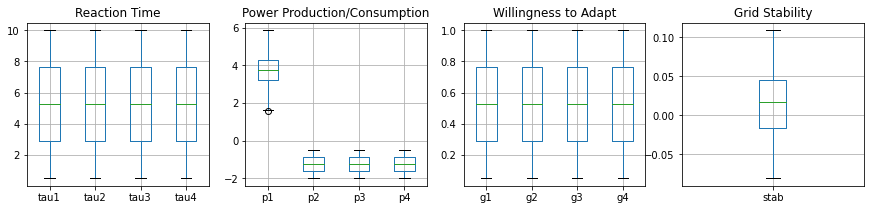

In [13]:
fig, axs = plt.subplots(1, 4, figsize=(15, 3))
feature_groups = ["tau", "p", "g", "stab"]
titles = ["Reaction Time", "Power Production/Consumption",
          "Willingness to Adapt", "Grid Stability"]

for i, feature_group in enumerate(feature_groups):
    if feature_group != "stab":  # For 'tau', 'p', 'g'
        columns = [feature_group + str(j + 1) for j in range(4)]
    else:  # For 'stab'
        columns = [feature_group]

    smart_grid_orig.boxplot(column=columns, ax=axs[i])

    axs[i].set(title=titles[i])

plt.show()


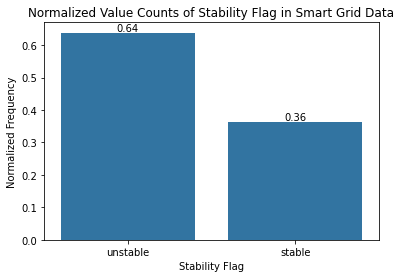

In [14]:
import matplotlib.pyplot as plt

normalized_value_counts = smart_grid['stabf'].value_counts(normalize=True)
sns.barplot(x=normalized_value_counts.index, y=normalized_value_counts.values)

plt.xlabel('Stability Flag')
plt.ylabel('Normalized Frequency')
plt.title('Normalized Value Counts of Stability Flag in Smart Grid Data')

for index, value in enumerate(normalized_value_counts.values):
    plt.text(index, value, f'{value:.2f}', ha='center', va='bottom')

plt.show()



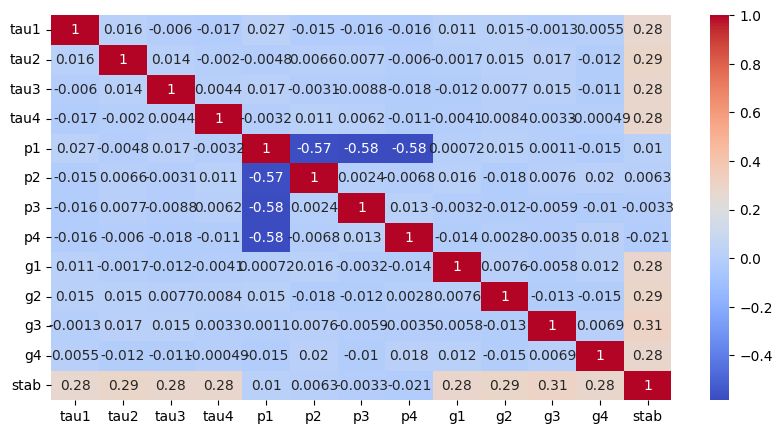

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the size of the figure
plt.figure(figsize=(10, 5))

# Compute the correlation matrix
corr = smart_grid.corr()

# Generate a heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm')

# Show the plot
plt.show()


## Correlation Matrix Heatmap Observations

### Negative Correlations
- Variables `p1`, `p2`, `p3`, and `p4` exhibit **moderate to strong negative correlations** with each other, indicating that as one variable increases, the others tend to decrease.

### Positive Correlations
- Variables `g1`, `g2`, `g3`, and `g4` demonstrate **positive correlations** with stab, which suggests that these variables tend to increase together.

### Stability Variable Correlations
- The `stab` variable displays a **weak to moderate positive correlation** with `tau1`, `tau2`, `tau3`, and `tau4`, implying a slight to moderate tendency to move together.
- There is **almost no correlation** between the `stab` variable and `p1`, `p2`, `p3`, and `p4`, suggesting that changes in `stab` do not consistently relate to changes in these variables.

p1 has corelation with p2, p3, p4

Checking for multicollinearity

In [ ]:
features = smart_grid.drop(["stab", "stabf"], axis=1).columns

(pd.DataFrame({
    "variables": smart_grid[features].columns,
    "VIF": [VIF(smart_grid[features].values, ind)
            for ind in range(len(features))]
})
 .rename({"variables": ""}, axis=1)

 .set_index("")
 .transpose()
)

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4
VIF,4.411883,4.373177,4.387577,4.342155,inf,inf,inf,inf,4.358228,4.39541,4.3677,4.321428


From the above we can see that both pearson and variance inflation factor states power column may be collinear and having a relationship power1 = abs(power2 + power3 + power4). So we can take out power1 column

# PreProcessing

In [15]:
smart_grid = smart_grid_orig.assign(stabf = lambda x: x.stabf.replace({"unstable": 0, "stable": 1}))

smart_grid.columns = (smart_grid.columns
                      .str.replace("tau", "delay")
                      .str.replace("p", "power")
                      .str.replace("g", "adapt"))

In [16]:
smart_grid.head()

,delay1,delay2,delay3,delay4,power1,power2,power3,power4,adapt1,adapt2,adapt3,adapt4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,0
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,1
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,0
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,0
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,0


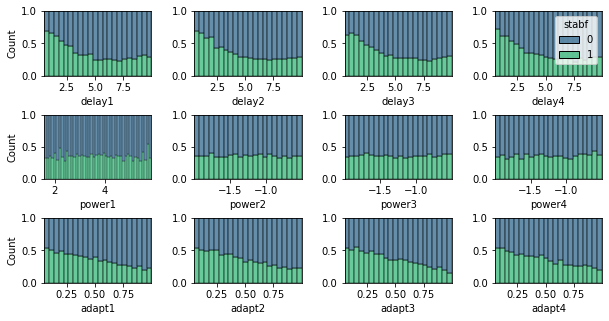

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define a custom color palette
custom_palette = sns.color_palette("viridis", n_colors=2)

# Create subplots with 3 rows and 4 columns
fig, axs = plt.subplots(3, 4, figsize=(10, 5))
plt.subplots_adjust(wspace=0.4, hspace=0.6)

# Feature types
feature_types = ["delay", "power", "adapt"]

# Generate plots
for row_idx, feature in enumerate(feature_types):
    for col_idx in range(4):
        ax = axs[row_idx, col_idx]
        show_legend = (row_idx == 0 and col_idx == 3)
        sns.histplot(
            smart_grid, x=f'{feature}{col_idx + 1}', hue="stabf",
            multiple="fill", legend=show_legend, palette=custom_palette,
            ax=ax
        )
        if col_idx > 0:
            ax.set_ylabel("")

plt.show()


Share of Unstable Events:
- The prevalence of unstable events demonstrated an upward trend with increasing reaction delay, encompassing both producers and consumers. This trend persisted until approximately 5 seconds, beyond which further increments in delay times appeared to have little impact on the share of unstable events.

- The share of unstable events exhibited a consistent linear increase with the willingness to adapt, observed in both producers and consumers.

- Interestingly, the occurrence of unstable events appeared to show no notable correlation with the quantity of power either produced or consumed.

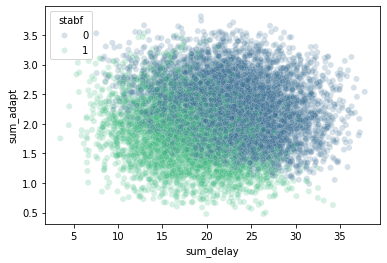

In [18]:
# Adding columns for the sum of delay and adapt values
smart_grid_temp = smart_grid.assign(
    sum_delay = lambda x: x["delay1"] + x["delay2"] + x["delay3"] + x["delay4"],
    sum_adapt = lambda x: x["adapt1"] + x["adapt2"] + x["adapt3"] + x["adapt4"]
)

# Creating a scatter plot to visualize the relationship between total delay, total adapt, and stability
sns.scatterplot(data=smart_grid_temp, x="sum_delay", y="sum_adapt", hue="stabf", alpha=0.2,palette=custom_palette)

plt.show()

The aggregation of delay and adapt values into sum_delay and sum_adapt is introduced to explore their relationship with stability classes. While high or low sums of these aggregated values could serve as stability indicators, it is acknowledged that without additional processing, these summarized features would likely exhibit high correlation with the existing individual features. Therefore, the decision is made to retain the original individual features for a more detailed understanding of the dataset.

# Modelling

## Regression

### **LINEAR REGRESSION**

In [21]:
X = smart_grid.drop(["power1", "stab", "stabf"], axis=1)
y = smart_grid["stab"]

In [22]:
class LinearRegression:

    def __init__(self, X, y, learning_rate, epsilon, max_iteration, SGDiterations, batch_size, regularizer, gd, sgd) -> None:
      self.X=X
      self.y=y
      self.learning_rate=learning_rate
      self.epsilon=epsilon
      self.max_iteration=max_iteration
      self.regularizer = regularizer
      self.gd = gd
      self.sgd = sgd
      self.iterations_count=[]
      self.error_sequence=[]
      self.SGDiterations = SGDiterations
      self.batch_size = batch_size

    def split_data(self):
     X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=0.3, random_state=42)
     return X_train, X_test, y_train, y_test

    def add_X0(self,X):
      return np.column_stack([np.ones([X.shape[0], 1]), X])

    def normalize_train(self, X):
      mean = np.mean(X, 0)
      std = np.std(X, 0)
      train_norm = (X-mean)/std
      train_norm = self.add_X0(train_norm)
      # Return train mean and standard deviation to normalise test data to follow same distribution
      return train_norm, mean,std

    def normalize_test(self,X, mean,std):
      #normalize the test with train mean and std
       test_norm = (X - mean)/std
       test_norm = self.add_X0(test_norm)
       return test_norm

    def full_rank (self, X):
      #rank of matrix
        X_rank = np.linalg.matrix_rank(X)
        #check for full rank
        if X_rank == min(X.shape[0], X.shape[1]):
            self.fullRank = True
            print('Data is Full rank')
        else:
            self.fullRank = False
            print('Data is not Full rank')

    def low_rank(self,X):
      #check for low rank
      if X.shape[0]<X.shape[1]:
        self.lowRank = True
        print('Data is Low rank')
      else:
        self.lowRank = False
        print('Data is not Low rank')

    def closedFormSolution(self, X, y):
        self.theta = np.linalg.inv(X.T.dot(X) + self.regularizer*np.identity(X.shape[1])).dot(X.T).dot(y)
        return self.theta

    def gradientDescent(self, X, y):
        last_error = float('inf')
        for i in tqdm(range(self.SGDiterations)):
            self.theta = self.theta - self.learning_rate*(self.cost_derivative(X, y)+(self.regularizer*self.theta))
            current_error = self.sse(X, y)
            diff_eror = last_error - current_error
            last_error = current_error
            self.error_sequence.append(current_error)
            self.iterations_count.append(i)
            if abs(diff_eror) < self.epsilon:
                print('Model stopped learning')
                break

    def stochasticGD(self, X,y):
        last_error = float('inf')
        for i in tqdm(range(self.SGDiterations)):
            index = np.random.randint(0, X.shape[0],self.batch_size)
            X_sample, y_sample = X[index],y[index]
            self.theta = self.theta - self.learning_rate*(self.cost_derivative(X_sample, y_sample)+((self.regularizer*self.theta)))
            current_error = self.sse(X_sample, y_sample)
            diff_eror = last_error - current_error
            last_error = current_error
            self.error_sequence.append(current_error)
            self.iterations_count.append(i)
            if abs(diff_eror) < self.epsilon:
                print('Model stopped learning')
                break

    def predict(self, X):
      return X.dot(self.theta)

    def sse(self, X, y):
        y_hat = self.predict(X)
        return ((y_hat - y)**2).sum()

    def rmse(self, X, y):
      return np.sqrt(self.sse(X,y) / X.shape[0])

    def cost_derivative(self,X,y):
      y_hat=self.predict(X)
      return X.T.dot(y_hat-y)


    def plot_rmse(self):
        """
        @X: error_sequence, vector of rmse
        @does: Plots the error function
        @return: plot
        """
        # Data for plotting
        s = np.array(self.error_sequence)
        t = np.arange(s.size)

        fig, ax = plt.subplots()
        ax.plot(t, s)

        ax.set(xlabel='Iterations', ylabel='Cost',
               title='Iterations vs Cost')
        ax.grid()
        plt.show()

    def fit(self):
        self.X_train, self.X_test, self.y_train, self.y_test = self.split_data()
        self.X_train, self.mean, self.std = self.normalize_train(self.X_train)
        self.X_test = self.normalize_test(self.X_test, self.mean, self.std)
        self.low_rank(self.X_train)
        self.full_rank(self.X_train)

        if self.fullRank and not self.lowRank and not self.gd and not self.sgd and self.X_train.shape[0] < 10000:
            print('Solving using normal equation...[Closed form]')
            self.theta = self.closedFormSolution(self.X_train, self.y_train)

        elif self.gd and not self.sgd:
            print('Solving using gradient descent........')
            self.theta = np.zeros(self.X_train.shape[1], dtype = np.float64)
            self.gradientDescent(self.X_train, self.y_train)

        else:
            print('Solving using stochastic gradient descent.......')
            self.theta = np.zeros(self.X_train.shape[1], dtype = np.float64)
            self.stochasticGD(self.X_train, self.y_train)
        print('SSE error over test set:',self.sse(self.X_test,self.y_test))
        print('')
        print('RMSE error over test set:',(self.sse(self.X_test,self.y_test)/self.X_test.shape[0])**(1/2))
        print('')

        print(self.theta)
        y_pred = self.predict(self.X_test)
        print(y_pred)

In [23]:
smartgrid_regression = LinearRegression(X, y, regularizer=1,
                             learning_rate=0.0004, epsilon=0.005,SGDiterations = 100, batch_size= 1,
                              gd = False ,sgd = False, max_iteration=50000)

In [24]:
smartgrid_regression.fit()

Data is not Low rank
Data is Full rank
Solving using normal equation...[Closed form]
SSE error over test set: 1.473078909984037

RMSE error over test set: 0.022159113324499522

[ 0.01564525  0.00982774  0.01028214  0.01039477  0.01039622 -0.00018833
  0.00051115 -0.00039898  0.01034879  0.01048419  0.01096147  0.0104519 ]
[ 0.0384565   0.03563544  0.01013243 ...  0.04659264 -0.02471048
  0.06656399]


Mean Squared Error: 0.00
R-squared (R2) Score: 0.82
Mean Absolute Error (MAE): 0.01
Root Mean Squared Error (RMSE): 0.02


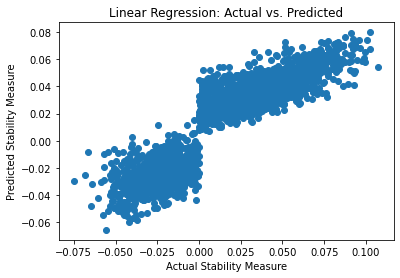

In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Assuming 'smart_grid' is your DataFrame with the dataset
# If your data is in a CSV file, you can read it like this:
# smart_grid = pd.read_csv('your_dataset.csv')

# Separate features (X) and target variable (y)
X = smart_grid.drop('stab', axis=1)
y = smart_grid['stab']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared (R2) Score: {r2:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
# Visualize predicted vs. actual values
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Stability Measure")
plt.ylabel("Predicted Stability Measure")
plt.title("Linear Regression: Actual vs. Predicted")
plt.show()


### **LOGISTIC REGRESSION**

In [28]:
X = smart_grid.drop(["power1", "stab", "stabf"], axis=1)
y = smart_grid['stabf'].map({'stable': 0, 'unstable': 1})

In [31]:
class LogisticRegression :
    def __init__(self, X, y, max_iteration, epsillon, learning_rate, index=[]):
        self.X=X
        self.y=y
        self.learning_rate = learning_rate
        self.max_iteration = max_iteration
        self.epsillon = epsillon
        self.index = index

    def split_data(self):
     X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=0.3, random_state=42)
     return X_train, X_test, y_train, y_test

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def cost_function (self, X, y):

        # approach_1 Log-loss function

        sig = self.sigmoid(X.dot(self.theta))
        cost = -(y * np.log(sig) + (1-y)*np.log(1-sig)).sum()
        cost = cost/X.shape[0]

        # approach_2 Negative Log likelihood

        #cost = (np.log(np.ones(X.shape[0]) + np.exp(X.dot(self.theta))) - X.dot(self.theta).dot(y)).sum()

        return cost

    def gradient(self, X, y):
        sig = self.sigmoid(X.dot(self.theta))
        grad = (sig - y).dot(X)
        return grad

    def gradient_descent(self,X ,y):
        errors = []
        last_error = float('inf')

        for i in tqdm(range(self.max_iteration)):
            self.theta = self.theta - self.learning_rate * self.gradient(X, y)
            current_error = self.cost_function(X, y)

            errors.append(current_error)
            diff_error = last_error - current_error
            last_error = current_error

            if np.abs(diff_error) < self.epsillon:
                print('Converged: model stopped learning.....')
                break

        return


    def predict(self, X):
        sig = self.sigmoid(X.dot(self.theta))
        return np.around(sig)

    def fit(self):
        self.X_train, self.X_test, self.y_train, self.y_test = self.split_data()

        print('solving using gradient descent.....')

        self.theta = np.zeros(self.X_train.shape[1], dtype = np.float64)
        self.gradient_descent(self.X_train, self.y_train)

        print(self.theta)

        y_hat = self.predict(self.X_test)
        accuracy, precision, recall = self.evaluate(self.y_test, y_hat)

        print('accuracy: ', accuracy)
        print('precision: ', precision)
        print('recall: ', recall)


    def evaluate(self, y, y_hat):
        y = (y == 1)
        y_hat = (y_hat == 1)

        recall = (y & y_hat).sum() / y.sum()
        precision = (y & y_hat).sum() / y_hat.sum()

        accuracy = (y == y_hat).sum() / y.size
        return accuracy, precision, recall



    def plot(self):
        plt.figure(figsize=(12, 8))
        ax = plt.axes(projection='3d')

        # Data for three-dimensional scattered points
        ax.scatter3D(self.X_test[:, 0], self.X_test[:, 1],
                     self.sigmoid(self.X_test.dot(self.theta)),
                     c = self.y_test[:], cmap='viridis', s=100);

        ax.set_xlim3d(55, 80)
        ax.set_ylim3d(80, 240)
        plt.xlabel('$x_1$ feature', fontsize=15)
        plt.ylabel('$x_2$ feature', fontsize=15, )
        ax.set_zlabel('$P(Y = 1|x_1, x_2)$', fontsize=15, rotation = 0)



    def scatterPlt(self):
        # evenly sampled points
        x_min, x_max = 55, 80
        y_min, y_max = 80, 240

        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 250),
                             np.linspace(y_min, y_max, 250))
        grid = np.c_[xx.ravel(), yy.ravel()]
        probs = grid.dot(self.theta).reshape(xx.shape)

        f, ax = plt.subplots(figsize=(14,12))


        ax.contour(xx, yy, probs, levels=[0.5], cmap="Greys", vmin=0, vmax=.6)


        ax.scatter(self.X_test[:, 0], self.X_test[:, 1],
                   c=self.y_test[:], s=50,
                   cmap="RdBu", vmin=-.2, vmax=1.2,
                   edgecolor="white", linewidth=1)

        plt.xlabel('x1 feature')
        plt.ylabel('x2 feature')


    def plot3D(self):
        # evenly sampled points
        x_min, x_max = 55, 80
        y_min, y_max = 80, 240

        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 250),
                             np.linspace(y_min, y_max, 250))

        grid = np.c_[xx.ravel(), yy.ravel()]
        probs = grid.dot(self.theta).reshape(xx.shape)
        fig = plt.figure(figsize=(14,12))
        ax = plt.axes(projection='3d')
        ax.contour3D(xx, yy, probs, 50, cmap='binary')

        ax.scatter3D(self.X_test[:, 0], self.X_test[:, 1],
                   c=self.y_test[:], s=50,
                   cmap="RdBu", vmin=-.2, vmax=1.2,
                   edgecolor="white", linewidth=1)

        ax.set_xlabel('x1')
        ax.set_ylabel('x2')
        ax.set_zlabel('probs')
        ax.set_title('3D contour')
        plt.show()


In [32]:
lr = LogisticRegression(X = smart_grid.drop(["power1", "stab", "stabf"], axis=1),y = smart_grid['stabf'], learning_rate=0.0001, epsillon=0.0005, max_iteration=10000)

In [33]:
lr.fit()

solving using gradient descent.....


  0%|          | 7/10000 [00:00<02:30, 66.37it/s]

 23%|██▎       | 2256/10000 [00:22<01:15, 102.27it/s]

Converged: model stopped learning.....
delay1   -0.841503
delay2   -0.818730
delay3   -0.907496
delay4   -0.779757
power2   -7.428670
power3   -7.644041
power4   -6.568817
adapt1   -4.957646
adapt2   -6.029386
adapt3   -6.053310
adapt4   -5.377701
dtype: float64
accuracy:  0.7053333333333334
precision:  0.5750636132315522
recall:  0.6390197926484449


### **NEURAL NETWORKS**

In [36]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

X = smart_grid.drop(['stab', 'stabf'], axis=1)
y = smart_grid['stabf']


y_encoded = pd.get_dummies(y, drop_first=True)


X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

def create_model():
    model = Sequential()
    model.add(Dense(32, activation='relu', input_dim=X_train.shape[1]))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Train the model
model = create_model()
model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, verbose=0)

# Make predictions on the test set
y_pred_proba = model.predict(X_test_scaled)


results_df = pd.DataFrame(columns=['Cutoff', 'Accuracy', 'Sensitivity'])

for cutoff in [0.3, 0.4, 0.5, 0.6, 0.7]:
    y_pred = (y_pred_proba > cutoff).astype(int)
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test.iloc[:, 0], y_pred[:, 0])
    TP = conf_matrix[0, 0]  # True Positives
    FN = conf_matrix[1, 0]  # False Negatives

    sensitivity = TP / (TP + FN)


    results_df = results_df.append({'Cutoff': cutoff, 'Accuracy': accuracy, 'Sensitivity': sensitivity}, ignore_index=True)

# Find the best cutoff
best_row = results_df.loc[results_df['Accuracy'].idxmax()]

# Print information about the best cutoff
print(f"\nBest Cutoff: {best_row['Cutoff']}")
print(f"Best Accuracy: {best_row['Accuracy']:.4f}")
print(f"Corresponding Sensitivity: {best_row['Sensitivity']:.4f}")
# Convert probability predictions to binary predictions based on the best cutoff
y_best_cutoff = (y_pred_proba > best_row['Cutoff']).astype(int)

# Print confusion matrix for the best cutoff
conf_matrix_best_cutoff = confusion_matrix(y_test.iloc[:, 0], y_best_cutoff[:, 0])
print("Confusion Matrix:")
print(conf_matrix_best_cutoff)

# Print results DataFrame
results_df

ModuleNotFoundError: No module named 'tensorflow.python'

## Classification

In [ ]:
df = smart_grid.copy()
df.head()

,delay1,delay2,delay3,delay4,power1,power2,power3,power4,adapt1,adapt2,adapt3,adapt4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,0
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,1
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,0
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,0
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,0


In [ ]:
X = df.drop(['power1','stabf'],axis=1)
y = df['stabf']

100%|██████████| 1000/1000 [00:01<00:00, 875.03it/s]


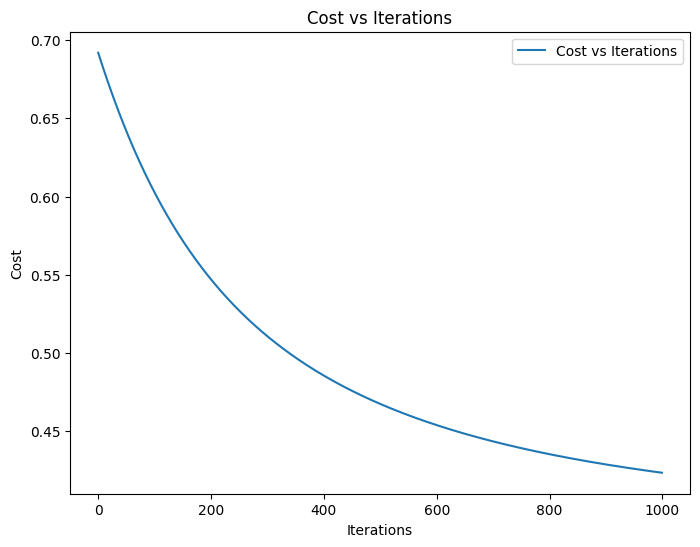

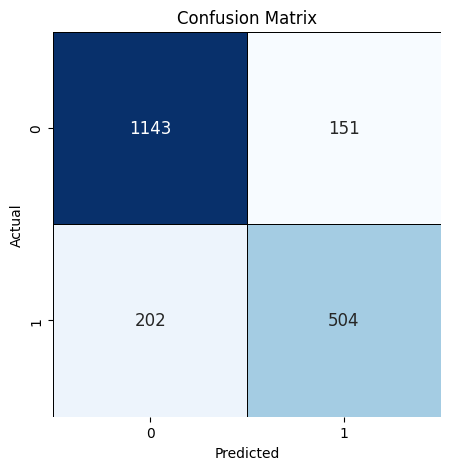

 10%|█         | 104/1000 [00:00<00:02, 390.02it/s]


Optimization complete


  0%|          | 0/1000 [00:00<?, ?it/s]


Optimization complete


,cutoff,precision,recall
0,0.2,0.769466,0.713881
1,0.4,0.769466,0.713881
2,0.6,0.767477,0.715297
3,0.8,0.767830,0.716714


In [ ]:
class BinaryClassifier:
    def __init__(self,X,y, iterations, threshold, alpha,results, exclude=[]):
        self.results=results
        self.X = X
        self.y = y
        self.alpha = alpha
        self.iterations = iterations
        self.threshold = threshold
        self.exclude = exclude
        self.iterations_count = []
        self.error_sequence = []

    def load_data(self):
        # Exclude specified rows
        if self.exclude:
            X = self.X.drop(self.exclude, axis=0)
            y = self.y.drop(self.exclude, axis=0)
        else:
            X = self.X
            y = self.y

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)
        scaler = StandardScaler()
        X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
        X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

        return X_train.values, X_test.values, y_train.values, y_test.values

    def activate(self, z):
        return 1 / (1 + np.exp(-z))

    def compute_cost(self, features, target):
        predictions = self.activate(features.dot(self.weights))
        loss = -(target * np.log(predictions) + (1 - target) * np.log(1 - predictions)).mean()
        return loss

    def compute_gradient(self, features, target):
        predictions = self.activate(features @ self.weights)  # Using @ for matrix multiplication
        gradient = features.T @ (predictions - target) / len(features)
        return gradient

    def optimize(self, features, target):
        # Adding a bias term to the features
        features = np.hstack([np.ones((features.shape[0], 1)), features])

        # Initialize weights with an additional term for the bias
        self.weights = np.zeros(features.shape[1])

        for _ in tqdm(range(self.iterations)):
            self.weights -= self.alpha * self.compute_gradient(features, target)
            error = self.compute_cost(features, target)
            if np.abs(error) < self.threshold:
                print('Optimization complete')
                break
            self.iterations_count.append(_)
            self.error_sequence.append(error)


    def exclude_indices(self, features, target):
        if self.exclude:
            features = np.delete(features, self.exclude, axis=0)
            target = np.delete(target, self.exclude)
        return features, target

    def train(self):
        self.features_train, self.features_test, self.target_train, self.target_test = self.load_data()
        self.features_train, self.target_train = self.exclude_indices(self.features_train, self.target_train)
        self.optimize(self.features_train, self.target_train)

    def predict(self, features):
    # Adding a bias term to the features for prediction
        features_with_bias = np.hstack([np.ones((features.shape[0], 1)), features])
        return np.round(self.activate(features_with_bias.dot(self.weights)))

    def store_results(self, a, p, r):
        self.results['Logistic_Regression'] = {'Accuracy': a, 'Precision': p, 'Recall': r}


    def assess_performance(self, actual, predicted):
        true_positive = np.sum((actual == 1) & (predicted == 1))
        precision = true_positive / np.sum(predicted == 1) if np.sum(predicted == 1) > 0 else 0
        recall = true_positive / np.sum(actual == 1) if np.sum(actual == 1) > 0 else 0
        accuracy = np.mean(actual == predicted)

        # Correctly calling the store_results method
        self.store_results(accuracy, precision, recall)
        return accuracy, precision, recall






    def fit(self):
        self.features_train, self.features_test, self.target_train, self.target_test = self.load_data()

        # Exclude specified indices
        if self.exclude and max(self.exclude, default=0) < len(self.features_train):
            print('Removing specified indices...')
            self.features_train, self.target_train = self.exclude_indices(self.features_train, self.target_train)
        else:
            print('No records are found for the specified indices.')

        print('Solving using gradient descent...')
        self.optimize(self.features_train, self.target_train)

        # Making predictions on the test set
        predictions = self.predict(self.features_test)

        # Evaluating the model
        accuracy, precision, recall = self.assess_performance(self.target_test, predictions)

        # Print the evaluation metrics
        print(f'Accuracy: {accuracy}')
        print(f'Precision: {precision}')
        print(f'Recall: {recall}')

    def confusion_matrix(self, actual, predicted):
        return confusion_matrix(actual, predicted)

    def plot_confusion_matrix(self, cm):
        plt.figure(figsize=(5, 5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                    annot_kws={"fontsize": 12}, linewidths=0.5, linecolor="black")
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

    def bias_variance_tradeoff(self, cutoff_values):
        tradeoff_results = []

        for cutoff in cutoff_values:
            self.threshold = cutoff
            self.optimize(self.features_train, self.target_train)
            predictions = self.predict(self.features_test)
            _, precision, recall = self.assess_performance(self.target_test, predictions)

            tradeoff_results.append({'cutoff': cutoff, 'precision': precision, 'recall': recall})

        return pd.DataFrame(tradeoff_results)

    def plot_cost_vs_iterations(self):
         plt.figure(figsize=(8, 6))
         plt.plot(self.iterations_count, self.error_sequence, label='Cost vs Iterations')
         plt.title('Cost vs Iterations')
         plt.xlabel('Iterations')
         plt.ylabel('Cost')
         plt.legend()
         plt.show()

classifier = BinaryClassifier(X=smart_grid.drop(['stab', 'stabf'], axis=1),
                              y=smart_grid['stabf'],
                              iterations=1000,
                              threshold=1e-5,
                              alpha=0.01,
                              results={},
                              exclude=[])
classifier.train()

# Plot cost vs iterations
classifier.plot_cost_vs_iterations()
# Add confusion matrix
predictions = classifier.predict(classifier.features_test)
cm = classifier.confusion_matrix(classifier.target_test, predictions)
classifier.plot_confusion_matrix(cm)

# Perform bias-variance tradeoff for different cutoff values
cutoff_values = [0.2, 0.4, 0.6, 0.8]
tradeoff_results_df = pd.DataFrame(classifier.bias_variance_tradeoff(cutoff_values))

tradeoff_results_df

In [ ]:
results_dict = {}
classifier = BinaryClassifier(X=X, y=y, iterations=10000, threshold=0.0005, alpha=0.0001, results=results_dict)
classifier.fit()

print(results_dict)


No records are found for the specified indices.
Solving using gradient descent...


100%|██████████| 10000/10000 [00:12<00:00, 832.68it/s]

Accuracy: 0.912
Precision: 0.8200483091787439
Recall: 0.9617563739376771
{'Logistic_Regression': {'Accuracy': 0.912, 'Precision': 0.8200483091787439, 'Recall': 0.9617563739376771}}


Binary Classifier is giving Accuracy of 91% which is pretty good
